# Steerable Pyramid Demo
Steerable pyramids decompose an image into severabl bands corresponding to different orientations and spatial scales. For a walkthrough of the basic functionalities of the plenoptic implementation of the steerable pyramid see [here](https://github.com/LabForComputationalVision/plenoptic/blob/master/examples/03_Steerable_Pyramid.ipynb), and for even more details on steerable pyramids and how they are built see [here]( https://pyrtools.readthedocs.io/en/latest/)

While this type of decomposition is often learned in the early stages of deep networks trained on computer vision tasks, using a Steerable pyramid as a front end offers theoretical guarantees about the information contained in the early stages and can reduce the number of learnable parameters necessary for a given task, and can allow the network to "focus," on learning more complicated features as soon as training begins. While similar representations can often be learned by the early stages of deep networks trained on computer vision tasks, using a Steerable pyramid as a front end offers theoretical guarantees about the information contained in the early stages and can reduce the number of learnable parameters necessary for a given task, and can allow the network to "focus," on learning more complicated features as soon as training begins.

In [45]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch import nn
import matplotlib.pyplot as plt

import pyrtools as pt
import plenoptic as po
from plenoptic.tools.signal import rcosFn, pointOp
%matplotlib inline

from plenoptic.simulate import Steerable_Pyramid_Freq
from plenoptic.tools.display import convert_pyrshow
from plenoptic.tools.data import torch_complex_to_numpy, to_numpy
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# First we define/download the dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/Users/tyerxa/opt/anaconda3/envs/plenoptic/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [25]:
# Define a simple model: SteerPyr --> ConvLayer --> Fully Connected
class PyrConvFull(nn.Module):
    def __init__(self, imshape, order, scales, kernel_size, exclude = [], output_dim = 10, is_complex = True):
        super(PyrConvFull, self).__init__()
        
        self.imshape = imshape
        self.order = order
        self.scales = scales
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.exclude = exclude
        self.is_complex = is_complex
        
        self.rect = nn.ReLU(inplace = True)
        self.pyr = Steerable_Pyramid_Freq(height=self.scales,image_shape=self.imshape,
                                          order=self.order,is_complex = self.is_complex,twidth=1, downsample=False)
        
        #channels number of scales * number of orientations * 2 (for the real/imag)
        self.pyr_channels = (self.order+1)*self.scales*2
        self.conv = nn.Conv2d(in_channels = self.pyr_channels,kernel_size = self.kernel_size, 
                              out_channels= self.output_dim, stride = 2)
        output_size = ((self.imshape[0] - self.kernel_size) / 2 + 1) ** 2
        n_feats = int(output_size * self.output_dim)
        self.fc = nn.Linear(in_features=n_feats, out_features=10)
        
    def forward(self, x):
        out = self.pyr(x)
        # first and last channels are the residuals, so drop them
        out = out[:, 1:-1]
        out = self.rect(out)
        out = self.conv(out)
        out = self.rect(out)
        out = out.view(out.shape[0], -1) # reshape for linear layer
        out = self.fc(out) # going to use cross entropy loss so no need for softmax

        return out

Text(0, 0.5, 'Cross Entropy Los')

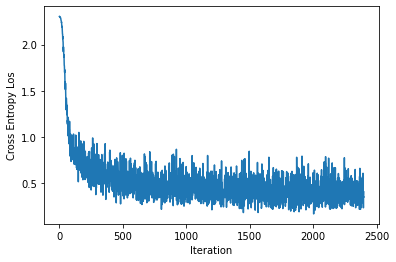

In [42]:
# Training
model = PyrConvFull([28, 28], order=4, scales=2, kernel_size=6, output_dim=3)
loader = torch.utils.data.DataLoader(train_set, batch_size = 50)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


epoch = 2
losses = []
for e in range(epoch):
    for batch in loader:
        images = batch[0]
        labels = batch[1]
        preds = model(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        c += 1
        
        losses.append(loss.item())
        
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')

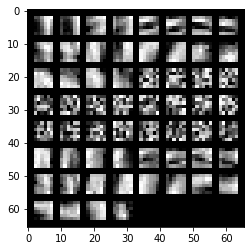

In [60]:
# Feature Visualization
conv_weights = model.conv.weight.detach().view(-1, 1, 6, 6)
conv_weights = make_grid(conv_weights, normalize=True, scale_each=True)
conv_weights = conv_weights.numpy()
conv_weights = np.transpose(conv_weights, (1, 2, 0))
plt.imshow(conv_weights, cmap='gray')